## code

In [1]:
from keras import layers
import keras

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from sklearn.metrics import roc_auc_score
import cv2
import random
from glob import glob
import torch

In [3]:
positional_emb = True
conv_layers = 2
projection_dim = 256

num_heads = 8
transformer_units = [projection_dim, projection_dim,

]
transformer_layers = 2
stochastic_depth_rate = 0.4

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 100
image_size = 224
input_shape=(image_size,image_size,3)

In [4]:

import kagglehub
# Download latest version
path = kagglehub.dataset_download("ipythonx/mvtec-ad")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mvtec-ad


In [5]:
import os

print(os.listdir(path))


['wood', 'screw', 'metal_nut', 'capsule', 'readme.txt', 'hazelnut', 'carpet', 'pill', 'license.txt', 'grid', 'zipper', 'transistor', 'tile', 'leather', 'toothbrush', 'bottle', 'cable']


In [6]:
def load_mvtec_images(dataset_path, classe, target_size=(224, 224)):
    images, labels = [], []
    # Train uniquement "good" (normal)
    train_good_path = os.path.join(dataset_path, classe, "train", "good")
    for img_file in os.listdir(train_good_path):
        img_path = os.path.join(train_good_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(0)  # 0 = normal

    # Test: contient "good" et les anomalies
    test_dir = os.path.join(dataset_path, classe, "test")
    for defect_type in os.listdir(test_dir):
        label = 0 if defect_type == "good" else 1
        defect_path = os.path.join(test_dir, defect_type)
        for img_file in os.listdir(defect_path):
            img_path = os.path.join(defect_path, img_file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

In [7]:
import matplotlib.pyplot as plt
def plot_images(images, labels, n):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.axis("off")
        plt.title(f"Label: {labels[i]}")
    plt.show()


In [8]:
import numpy as np

def shuffle_data(images, labels):

    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images_shuffled = images[indices]
    labels_shuffled = labels[indices]
    return images_shuffled, labels_shuffled


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def balance_dataset_with_augmentation(x_train, y_train, minority_class=1, batch_size=32):

    # Séparer les classes
    x_minority = x_train[y_train == minority_class]
    y_minority = y_train[y_train == minority_class]
    x_majority = x_train[y_train != minority_class]

    # Nombre d'échantillons à générer
    N = len(x_majority) - len(x_minority)

    if N <= 0:
        print("Les classes sont déjà équilibrées ou la classe minoritaire est majoritaire.")
        return x_train, y_train

    # Définir le générateur de data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Générer des images augmentées
    augmented_images = []
    augmented_labels = []


    for batch in datagen.flow(x_minority, y_minority, batch_size=batch_size, shuffle=True):
        for img, label in zip(batch[0], batch[1]):
            augmented_images.append(img)
            augmented_labels.append(label)
            if len(augmented_images) >= N:
                break
        if len(augmented_images) >= N:
            break

    # Concaténer avec les données originales
    x_balanced = np.concatenate([x_train, np.array(augmented_images)])
    y_balanced = np.concatenate([y_train, np.array(augmented_labels)])

    # Mélanger
    indices = np.arange(len(x_balanced))
    np.random.shuffle(indices)
    x_balanced = x_balanced[indices]
    y_balanced = y_balanced[indices]

    return x_balanced, y_balanced


In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.ops.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [11]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [12]:
class SequencePooling(layers.Layer):
    def __init__(self):
        super().__init__()
        self.attention = layers.Dense(1)

    def call(self, x):
        attention_weights = keras.ops.softmax(self.attention(x), axis=1)
        attention_weights = keras.ops.transpose(attention_weights, axes=(0, 2, 1))
        weighted_representation = keras.ops.matmul(attention_weights, x)
        return keras.ops.squeeze(weighted_representation, -2)

In [13]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (keras.ops.shape(x)[0],) + (1,) * (len(x.shape) - 1)
            random_tensor = keep_prob + keras.random.uniform(
                shape, 0, 1, seed=self.seed_generator
            )
            random_tensor = keras.ops.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [14]:
class PositionEmbedding(keras.layers.Layer):
    def __init__(
        self,
        sequence_length,
        initializer="glorot_uniform",
        **kwargs,
    ):
        super().__init__(**kwargs)
        if sequence_length is None:
            raise ValueError("`sequence_length` must be an Integer, received `None`.")
        self.sequence_length = int(sequence_length)
        self.initializer = keras.initializers.get(initializer)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "initializer": keras.initializers.serialize(self.initializer),
            }
        )
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.position_embeddings = self.add_weight(
            name="embeddings",
            shape=[self.sequence_length, feature_size],
            initializer=self.initializer,
            trainable=True,
        )

        super().build(input_shape)

    def call(self, inputs, start_index=0):
        shape = keras.ops.shape(inputs)
        feature_length = shape[-1]
        sequence_length = shape[-2]
        # trim to match the length of the input sequence, which might be less
        # than the sequence_length of the layer.
        position_embeddings = keras.ops.convert_to_tensor(self.position_embeddings)
        position_embeddings = keras.ops.slice(
            position_embeddings,
            (start_index, 0),
            (sequence_length, feature_length),
        )
        return keras.ops.broadcast_to(position_embeddings, shape)

    def compute_output_shape(self, input_shape):
        return input_shape

In [15]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=5,
        num_output_channels=[16,32,64,128,256],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = keras.ops.reshape(
            outputs,
            (
                -1,
                keras.ops.shape(outputs)[1] * keras.ops.shape(outputs)[2],
                keras.ops.shape(outputs)[-1],
            ),
        )
        return reshaped

In [16]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)



    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        sequence_length = encoded_patches.shape[1]
        encoded_patches += PositionEmbedding(sequence_length=sequence_length)(
            encoded_patches
        )

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)


        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    weighted_representation = SequencePooling()(representation)

    # Classify outputs.
    logits = layers.Dense(1, activation="sigmoid")(weighted_representation)


    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [17]:
def run_experiment(model,x_train, y_train, x_test, y_test):
    optimizer = keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.00001)

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.1)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.AUC(name="AUC"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history


## wood

In [18]:

classe = "wood"


images, labels = load_mvtec_images(path, classe)

In [19]:
images = images / 255.0  # Normalisation

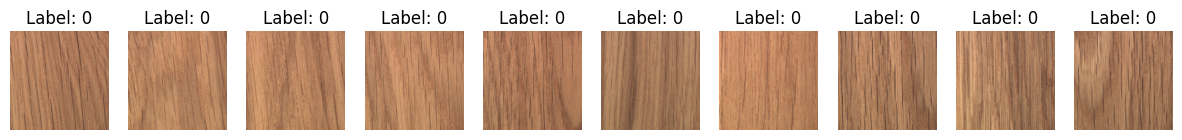

In [20]:
plot_images(images,labels,10)

In [21]:
images, labels = shuffle_data(images, labels)


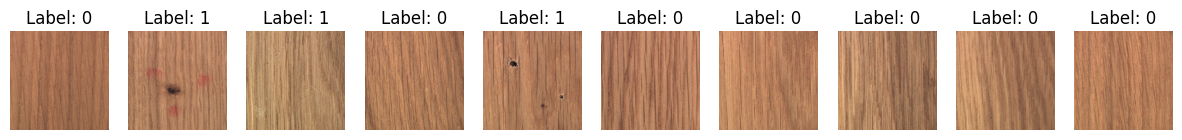

In [22]:
plot_images(images,labels,10)

In [23]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [24]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [266 266]


In [25]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [26]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [231 221]
Labels test distribution: [35 45]


In [27]:
cct_model = create_cct_model()

In [28]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 688ms/step - AUC: 0.4434 - accuracy: 0.4407 - loss: 1.0261 - val_AUC: 0.7827 - val_accuracy: 0.4130 - val_loss: 0.7176
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - AUC: 0.4904 - accuracy: 0.4607 - loss: 0.7579 - val_AUC: 0.7943 - val_accuracy: 0.4130 - val_loss: 0.6985
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - AUC: 0.5130 - accuracy: 0.4687 - loss: 0.7171 - val_AUC: 0.8099 - val_accuracy: 0.4783 - val_loss: 0.6889
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - AUC: 0.5704 - accuracy: 0.5241 - loss: 0.7083 - val_AUC: 0.7602 - val_accuracy: 0.4565 - val_loss: 0.6973
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.5419 - accuracy: 0.4964 - loss: 0.7045 - val_AUC: 0.8129 - val_accuracy: 0.4565 - val_loss: 0.6998
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - AUC: 0.5857 - accuracy: 0.5000 - loss: 0.6943 - val_AUC: 0.8177 - val_accuracy: 0.6087 - val_loss: 0.6649
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━

In [29]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 830ms/step


ROC AUC: 0.9974603174603174
Accuracy: 0.975
Precision: 0.9777777777777777
F1 Score: 0.9777777777777777
Recall (TPR): 0.9777777777777777
False Positive Rate (FPR): 0.0286


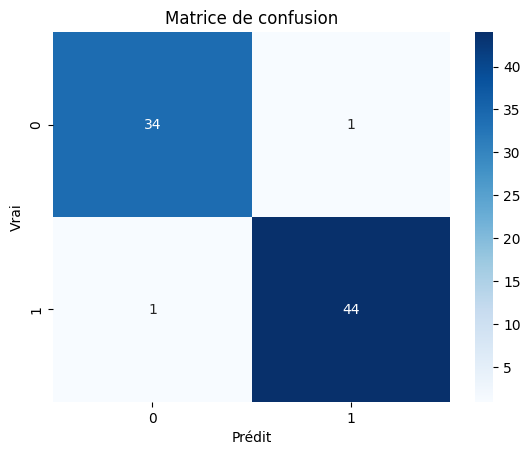

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## metal_nut

In [31]:

classe = "metal_nut"


images, labels = load_mvtec_images(path, classe)

In [32]:
images = images / 255.0  # Normalisation

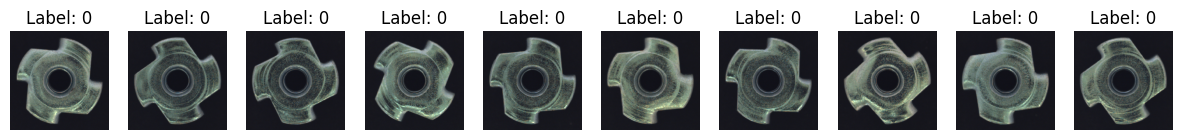

In [33]:
plot_images(images,labels,10)

In [34]:
images, labels = shuffle_data(images, labels)


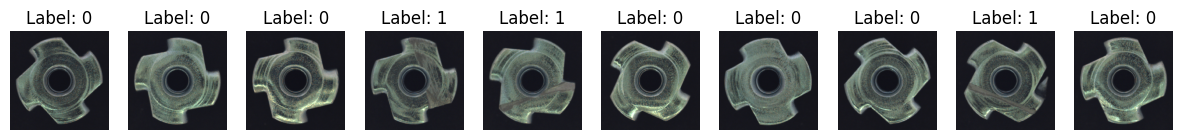

In [35]:
plot_images(images,labels,10)

In [36]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [37]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [242 242]


In [38]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [39]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [210 201]
Labels test distribution: [32 41]


In [40]:
cct_model = create_cct_model()

In [41]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 741ms/step - AUC: 0.4927 - accuracy: 0.4909 - loss: 0.9992 - val_AUC: 0.8822 - val_accuracy: 0.4524 - val_loss: 0.7471
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.6179 - accuracy: 0.5279 - loss: 0.7466 - val_AUC: 0.9188 - val_accuracy: 0.6429 - val_loss: 0.6050
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - AUC: 0.7129 - accuracy: 0.6539 - loss: 0.6366 - val_AUC: 0.8936 - val_accuracy: 0.7857 - val_loss: 0.4972
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.8163 - accuracy: 0.7428 - loss: 0.5587 - val_AUC: 0.9096 - val_accuracy: 0.8095 - val_loss: 0.5396
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.8564 - accuracy: 0.7780 - loss: 0.5181 - val_AUC: 0.9199 - val_accuracy: 0.8095 - val_loss: 0.4850
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.8955 - accuracy: 0.8085 - loss: 0.4882 - val_AUC: 0.9302 - val_accuracy: 0.8333 - val_loss: 0.4207
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━

In [42]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 800ms/step


ROC AUC: 0.958841463414634
Accuracy: 0.8904109589041096
Precision: 0.9714285714285714
F1 Score: 0.8947368421052632
Recall (TPR): 0.8292682926829268
False Positive Rate (FPR): 0.0312


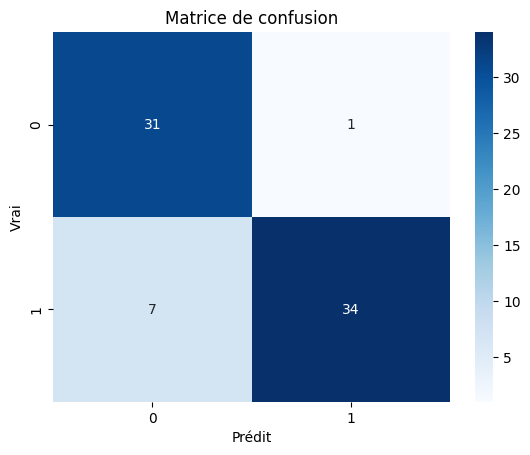

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## capsule

In [44]:

classe = "capsule"


images, labels = load_mvtec_images(path, classe)

In [45]:
images = images / 255.0  # Normalisation

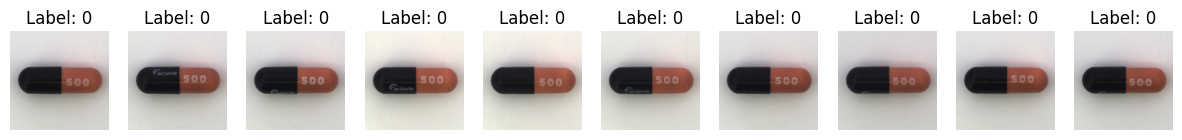

In [46]:
plot_images(images,labels,10)

In [47]:
images, labels = shuffle_data(images, labels)


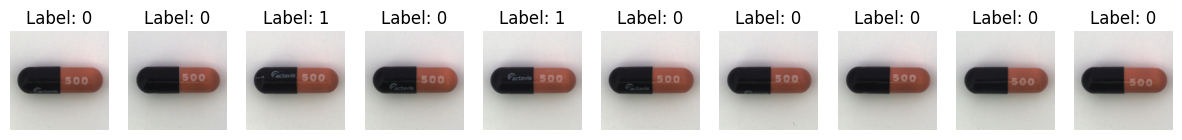

In [48]:
plot_images(images,labels,10)

In [49]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [50]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [242 242]


In [51]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [52]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [205 206]
Labels test distribution: [37 36]


In [53]:
cct_model = create_cct_model()

In [54]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 703ms/step - AUC: 0.4762 - accuracy: 0.4964 - loss: 0.9236 - val_AUC: 0.8124 - val_accuracy: 0.4524 - val_loss: 0.6870
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - AUC: 0.5023 - accuracy: 0.4801 - loss: 0.7226 - val_AUC: 0.8066 - val_accuracy: 0.4524 - val_loss: 0.7019
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - AUC: 0.6196 - accuracy: 0.5729 - loss: 0.7090 - val_AUC: 0.7986 - val_accuracy: 0.4524 - val_loss: 0.8479
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - AUC: 0.6378 - accuracy: 0.5920 - loss: 0.6796 - val_AUC: 0.8112 - val_accuracy: 0.5000 - val_loss: 0.6364
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - AUC: 0.7190 - accuracy: 0.6018 - loss: 0.6258 - val_AUC: 0.8307 - val_accuracy: 0.6429 - val_loss: 0.7157
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.7528 - accuracy: 0.6782 - loss: 0.6362 - val_AUC: 0.8055 - val_accuracy: 0.4524 - val_loss: 0.7128
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━

In [57]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


ROC AUC: 0.9159159159159158
Accuracy: 0.821917808219178
Precision: 1.0
F1 Score: 0.7796610169491526
Recall (TPR): 0.6388888888888888
False Positive Rate (FPR): 0.0000


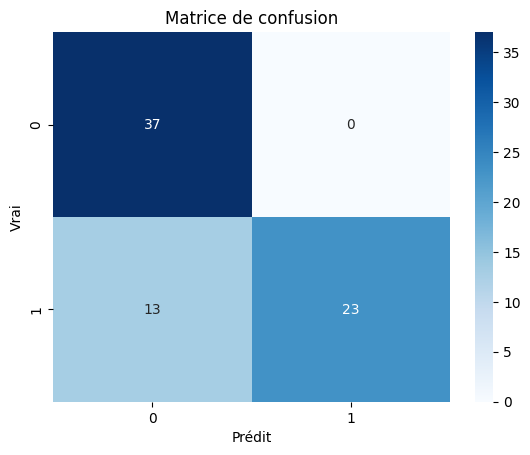

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## hazelnut

In [59]:

classe = "hazelnut"


images, labels = load_mvtec_images(path, classe)

In [60]:
images = images / 255.0  # Normalisation

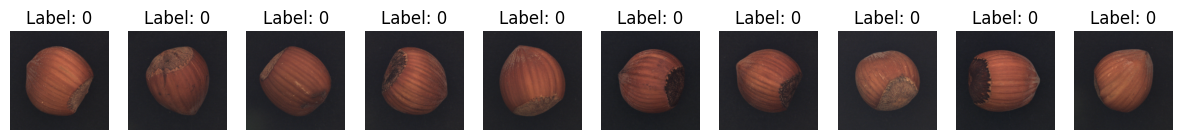

In [61]:
plot_images(images,labels,10)

In [62]:
images, labels = shuffle_data(images, labels)


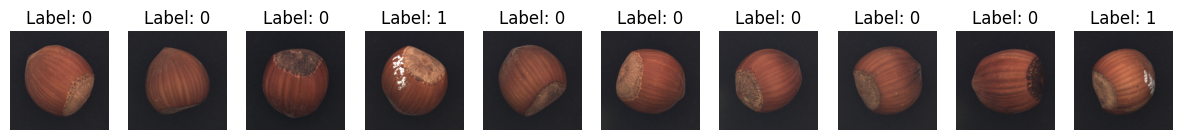

In [63]:
plot_images(images,labels,10)

In [64]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [65]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [431 431]


In [66]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [67]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [366 366]
Labels test distribution: [65 65]


In [68]:
cct_model = create_cct_model()

In [69]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - AUC: 0.4506 - accuracy: 0.4872 - loss: 0.9738 - val_AUC: 0.8766 - val_accuracy: 0.6486 - val_loss: 0.5951
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - AUC: 0.7254 - accuracy: 0.6160 - loss: 0.6452 - val_AUC: 0.8882 - val_accuracy: 0.7703 - val_loss: 0.4991
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - AUC: 0.8755 - accuracy: 0.7719 - loss: 0.4873 - val_AUC: 0.9603 - val_accuracy: 0.8378 - val_loss: 0.4167
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.9686 - accuracy: 0.9160 - loss: 0.3546 - val_AUC: 0.9848 - val_accuracy: 0.9324 - val_loss: 0.3340
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.9623 - accuracy: 0.8937 - loss: 0.3734 - val_AUC: 0.9876 - val_accuracy: 0.9459 - val_loss: 0.3294
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - AUC: 0.9925 - accuracy: 0.9652 - loss: 0.2810 - val_AUC: 0.9836 - val_accuracy: 0.9189 - val_loss: 0.4236
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━

In [70]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step


ROC AUC: 0.997396449704142
Accuracy: 0.9846153846153847
Precision: 0.9846153846153847
F1 Score: 0.9846153846153847
Recall (TPR): 0.9846153846153847
False Positive Rate (FPR): 0.0154


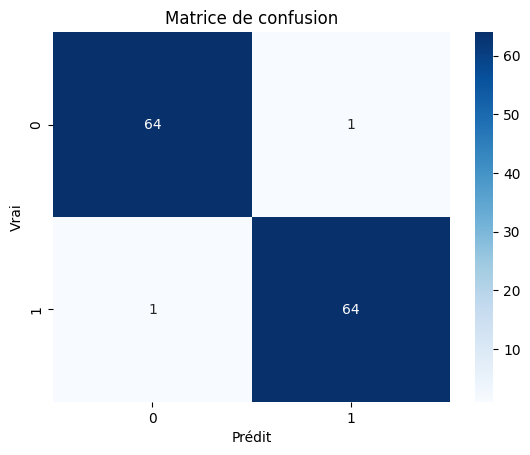

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## carpet

In [72]:

classe = "carpet"


images, labels = load_mvtec_images(path, classe)

In [73]:
images = images / 255.0  # Normalisation

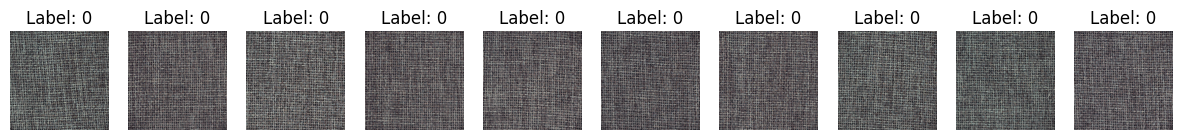

In [74]:
plot_images(images,labels,10)

In [75]:
images, labels = shuffle_data(images, labels)


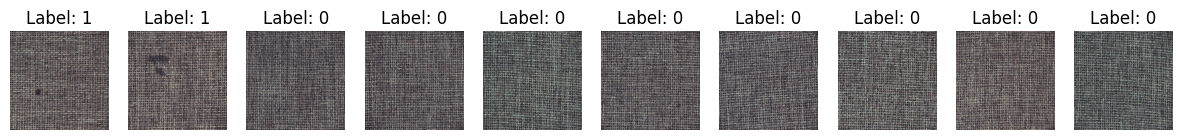

In [76]:
plot_images(images,labels,10)

In [77]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [78]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [308 308]


In [79]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [80]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [263 260]
Labels test distribution: [45 48]


In [81]:
cct_model = create_cct_model()

In [82]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 544ms/step - AUC: 0.4961 - accuracy: 0.5257 - loss: 1.0482 - val_AUC: 0.8788 - val_accuracy: 0.3774 - val_loss: 0.7593
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - AUC: 0.5957 - accuracy: 0.5759 - loss: 0.6880 - val_AUC: 0.9015 - val_accuracy: 0.8868 - val_loss: 0.5718
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - AUC: 0.8136 - accuracy: 0.7144 - loss: 0.5926 - val_AUC: 0.9348 - val_accuracy: 0.8868 - val_loss: 0.4183
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - AUC: 0.8824 - accuracy: 0.7998 - loss: 0.5050 - val_AUC: 0.9485 - val_accuracy: 0.3774 - val_loss: 1.4206
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.8456 - accuracy: 0.7200 - loss: 0.5980 - val_AUC: 0.9500 - val_accuracy: 0.8868 - val_loss: 0.3750
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.9036 - accuracy: 0.8484 - loss: 0.4566 - val_AUC: 0.9545 - val_accuracy: 0.8679 - val_loss: 0.4749
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━

In [83]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 957ms/step


ROC AUC: 0.9254629629629629
Accuracy: 0.9247311827956989
Precision: 0.9767441860465116
F1 Score: 0.9230769230769231
Recall (TPR): 0.875
False Positive Rate (FPR): 0.0222


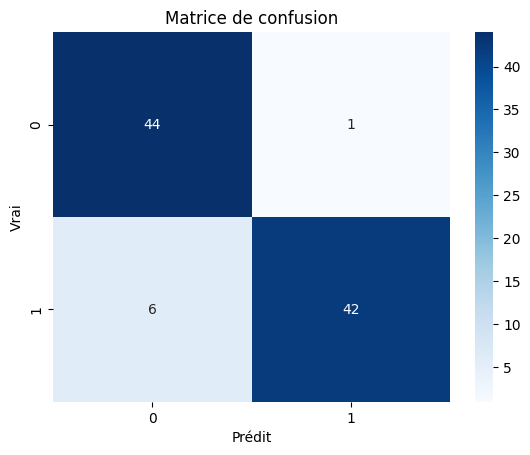

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## pill

In [85]:

classe = "pill"


images, labels = load_mvtec_images(path, classe)

In [86]:
images = images / 255.0  # Normalisation

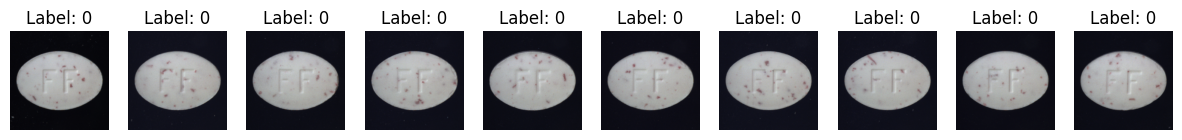

In [87]:
plot_images(images,labels,10)

In [88]:
images, labels = shuffle_data(images, labels)


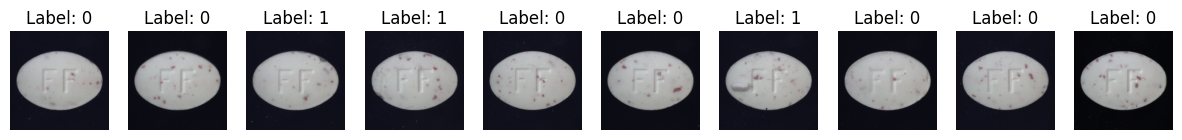

In [89]:
plot_images(images,labels,10)

In [90]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [91]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [293 293]


In [92]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [93]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [246 252]
Labels test distribution: [47 41]


In [94]:
cct_model = create_cct_model()

In [95]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - AUC: 0.4931 - accuracy: 0.4871 - loss: 1.1062 - val_AUC: 0.8268 - val_accuracy: 0.6200 - val_loss: 0.6640
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - AUC: 0.5067 - accuracy: 0.5000 - loss: 0.7474 - val_AUC: 0.8430 - val_accuracy: 0.7200 - val_loss: 0.6514
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - AUC: 0.6618 - accuracy: 0.6347 - loss: 0.6580 - val_AUC: 0.8472 - val_accuracy: 0.7200 - val_loss: 0.5729
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - AUC: 0.7593 - accuracy: 0.6875 - loss: 0.6193 - val_AUC: 0.8438 - val_accuracy: 0.7800 - val_loss: 0.5121
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - AUC: 0.8170 - accuracy: 0.7293 - loss: 0.5567 - val_AUC: 0.8455 - val_accuracy: 0.8800 - val_loss: 0.4993
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.7899 - accuracy: 0.7181 - loss: 0.5618 - val_AUC: 0.8447 - val_accuracy: 0.8800 - val_loss: 0.4828
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━

In [96]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step


ROC AUC: 0.9673066943435391
Accuracy: 0.8977272727272727
Precision: 0.9444444444444444
F1 Score: 0.8831168831168831
Recall (TPR): 0.8292682926829268
False Positive Rate (FPR): 0.0426


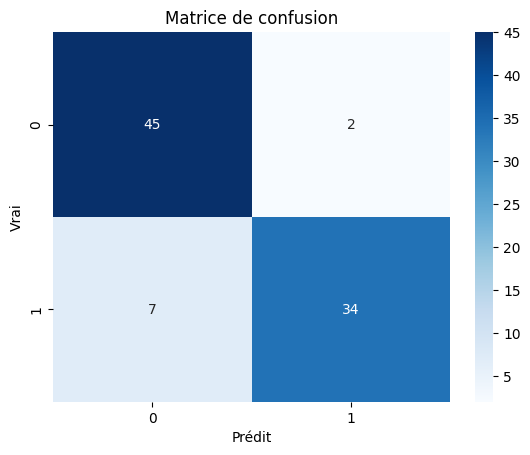

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## grid

In [98]:

classe = "grid"


images, labels = load_mvtec_images(path, classe)

In [99]:
images = images / 255.0  # Normalisation

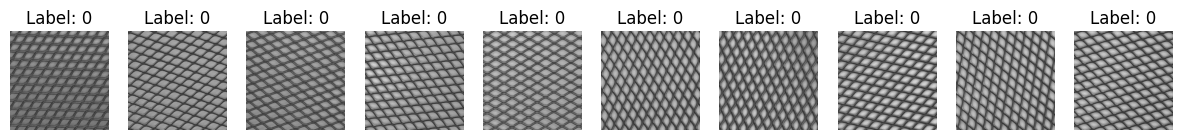

In [100]:
plot_images(images,labels,10)

In [101]:
images, labels = shuffle_data(images, labels)


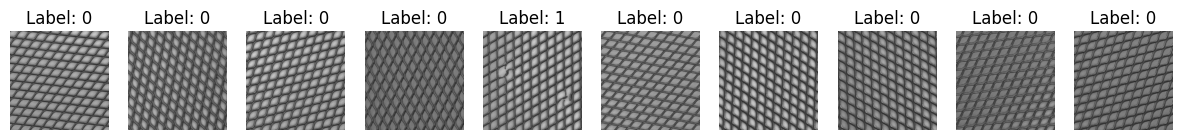

In [102]:
plot_images(images,labels,10)

In [103]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [104]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [285 285]


In [105]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [106]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [240 244]
Labels test distribution: [45 41]


In [107]:
cct_model = create_cct_model()

In [108]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 569ms/step - AUC: 0.5633 - accuracy: 0.5427 - loss: 0.9284 - val_AUC: 0.8583 - val_accuracy: 0.7551 - val_loss: 0.6035
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - AUC: 0.7291 - accuracy: 0.6806 - loss: 0.6278 - val_AUC: 0.8633 - val_accuracy: 0.8367 - val_loss: 0.5432
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - AUC: 0.8607 - accuracy: 0.7834 - loss: 0.5351 - val_AUC: 0.8792 - val_accuracy: 0.8163 - val_loss: 0.4752
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - AUC: 0.8724 - accuracy: 0.8053 - loss: 0.5035 - val_AUC: 0.8758 - val_accuracy: 0.8980 - val_loss: 0.4459
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - AUC: 0.8966 - accuracy: 0.8710 - loss: 0.4473 - val_AUC: 0.8792 - val_accuracy: 0.7143 - val_loss: 0.5136
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - AUC: 0.9097 - accuracy: 0.8386 - loss: 0.4434 - val_AUC: 0.8775 - val_accuracy: 0.8571 - val_loss: 0.4428
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━

In [111]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


ROC AUC: 0.9289972899728998
Accuracy: 0.9069767441860465
Precision: 0.9230769230769231
F1 Score: 0.9
Recall (TPR): 0.8780487804878049
False Positive Rate (FPR): 0.0667


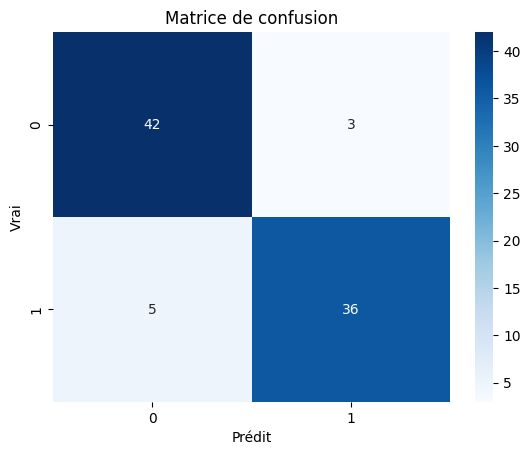

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## zipper

In [126]:

classe = "zipper"


images, labels = load_mvtec_images(path, classe)

In [127]:
images = images / 255.0  # Normalisation

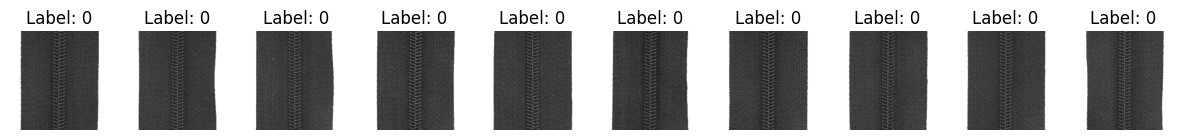

In [128]:
plot_images(images,labels,10)

In [129]:
images, labels = shuffle_data(images, labels)


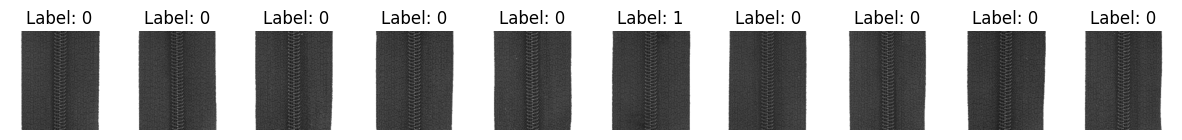

In [130]:
plot_images(images,labels,10)

In [131]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [132]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [272 272]


In [133]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [134]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [234 228]
Labels test distribution: [38 44]


In [135]:
cct_model = create_cct_model()

In [136]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 674ms/step - AUC: 0.5672 - accuracy: 0.5606 - loss: 0.8951 - val_AUC: 0.9483 - val_accuracy: 0.7872 - val_loss: 0.6332
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - AUC: 0.6117 - accuracy: 0.5697 - loss: 0.6774 - val_AUC: 0.9436 - val_accuracy: 0.8085 - val_loss: 0.5684
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - AUC: 0.8196 - accuracy: 0.7604 - loss: 0.5916 - val_AUC: 0.9380 - val_accuracy: 0.8723 - val_loss: 0.4690
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.8425 - accuracy: 0.8051 - loss: 0.5252 - val_AUC: 0.9558 - val_accuracy: 0.8723 - val_loss: 0.3846
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - AUC: 0.8685 - accuracy: 0.7898 - loss: 0.4920 - val_AUC: 0.9774 - val_accuracy: 0.9362 - val_loss: 0.3228
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - AUC: 0.9180 - accuracy: 0.8580 - loss: 0.4300 - val_AUC: 0.9887 - val_accuracy: 0.9362 - val_loss: 0.3091
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━

In [137]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


ROC AUC: 0.9766746411483255
Accuracy: 0.9024390243902439
Precision: 1.0
F1 Score: 0.9
Recall (TPR): 0.8181818181818182
False Positive Rate (FPR): 0.0000


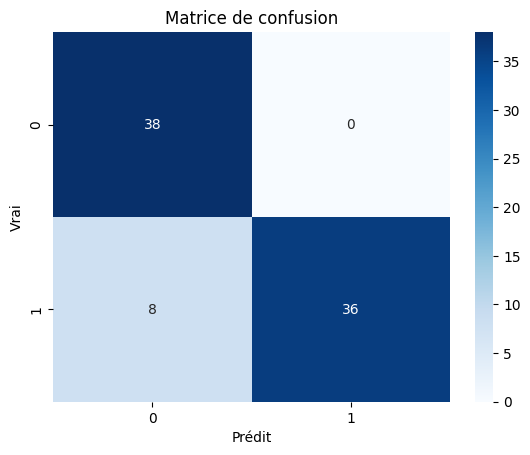

In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## transistor

In [139]:

classe = "transistor"


images, labels = load_mvtec_images(path, classe)

In [140]:
images = images / 255.0  # Normalisation

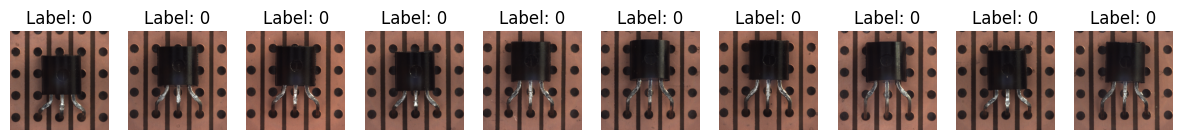

In [141]:
plot_images(images,labels,10)

In [142]:
images, labels = shuffle_data(images, labels)


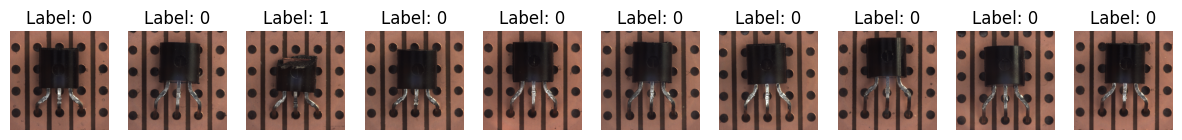

In [143]:
plot_images(images,labels,10)

In [144]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [145]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [273 273]


In [146]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [147]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [233 231]
Labels test distribution: [40 42]


In [148]:
cct_model = create_cct_model()

In [149]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 512ms/step - AUC: 0.4883 - accuracy: 0.4825 - loss: 1.0868 - val_AUC: 0.8534 - val_accuracy: 0.7660 - val_loss: 0.6656
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - AUC: 0.6714 - accuracy: 0.5877 - loss: 0.6617 - val_AUC: 0.8694 - val_accuracy: 0.7021 - val_loss: 0.5936
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - AUC: 0.7537 - accuracy: 0.6012 - loss: 0.6448 - val_AUC: 0.9032 - val_accuracy: 0.7872 - val_loss: 0.5468
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.8741 - accuracy: 0.7803 - loss: 0.5142 - val_AUC: 0.9427 - val_accuracy: 0.4681 - val_loss: 1.0842
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - AUC: 0.9034 - accuracy: 0.8072 - loss: 0.5032 - val_AUC: 0.9615 - val_accuracy: 0.8298 - val_loss: 0.6149
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - AUC: 0.9465 - accuracy: 0.8898 - loss: 0.4067 - val_AUC: 0.9568 - val_accuracy: 0.8936 - val_loss: 0.4720
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━

In [150]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 740ms/step


ROC AUC: 0.9994047619047619
Accuracy: 0.975609756097561
Precision: 1.0
F1 Score: 0.975609756097561
Recall (TPR): 0.9523809523809523
False Positive Rate (FPR): 0.0000


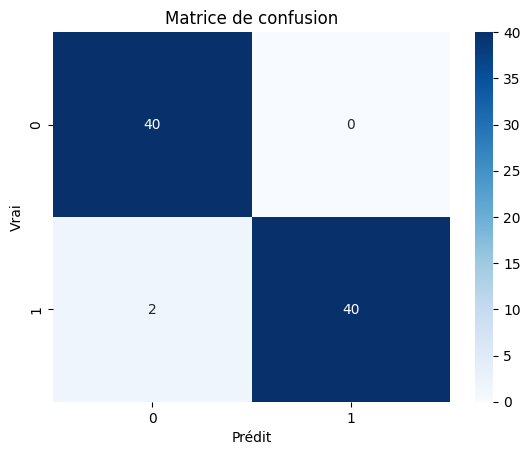

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## tile

In [152]:

classe = "tile"


images, labels = load_mvtec_images(path, classe)

In [153]:
images = images / 255.0  # Normalisation

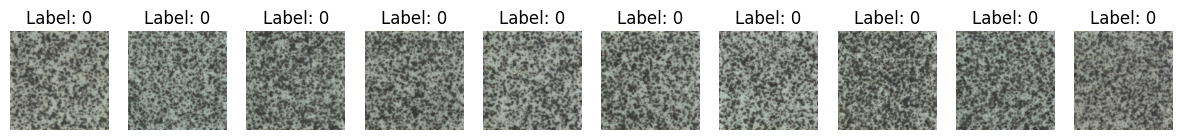

In [154]:
plot_images(images,labels,10)

In [155]:
images, labels = shuffle_data(images, labels)


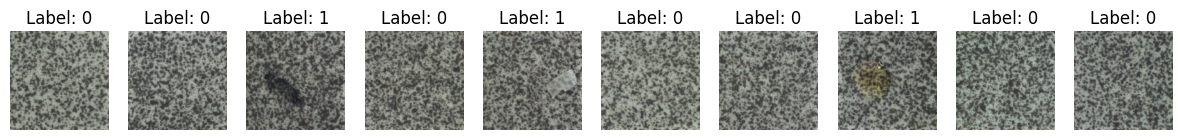

In [156]:
plot_images(images,labels,10)

In [157]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [158]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [263 263]


In [159]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [160]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [224 223]
Labels test distribution: [39 40]


In [161]:
cct_model = create_cct_model()

In [162]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 617ms/step - AUC: 0.5451 - accuracy: 0.5357 - loss: 0.8935 - val_AUC: 0.9773 - val_accuracy: 0.4889 - val_loss: 0.6970
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - AUC: 0.5569 - accuracy: 0.5048 - loss: 0.7316 - val_AUC: 0.9792 - val_accuracy: 0.5111 - val_loss: 0.6482
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.6818 - accuracy: 0.6367 - loss: 0.6580 - val_AUC: 0.9862 - val_accuracy: 0.4889 - val_loss: 0.6540
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - AUC: 0.6813 - accuracy: 0.6057 - loss: 0.6477 - val_AUC: 0.9783 - val_accuracy: 0.8667 - val_loss: 0.5010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.8937 - accuracy: 0.8143 - loss: 0.4982 - val_AUC: 0.9684 - val_accuracy: 0.8667 - val_loss: 0.5044
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - AUC: 0.9096 - accuracy: 0.7991 - loss: 0.4936 - val_AUC: 0.9664 - val_accuracy: 0.9111 - val_loss: 0.3786
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━

In [163]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 803ms/step


ROC AUC: 0.9942307692307693
Accuracy: 0.9113924050632911
Precision: 0.8666666666666667
F1 Score: 0.9176470588235294
Recall (TPR): 0.975
False Positive Rate (FPR): 0.1538


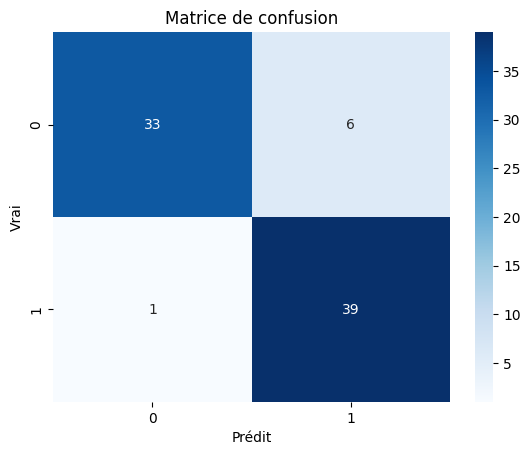

In [164]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## leather

In [165]:

classe = "leather"


images, labels = load_mvtec_images(path, classe)

In [166]:
images = images / 255.0  # Normalisation

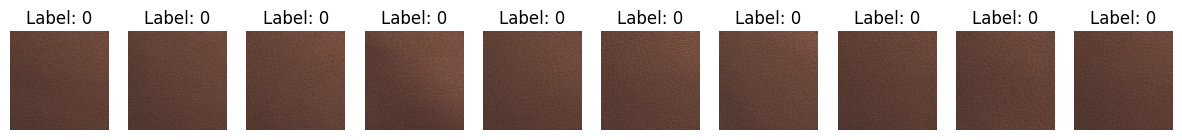

In [167]:
plot_images(images,labels,10)

In [168]:
images, labels = shuffle_data(images, labels)


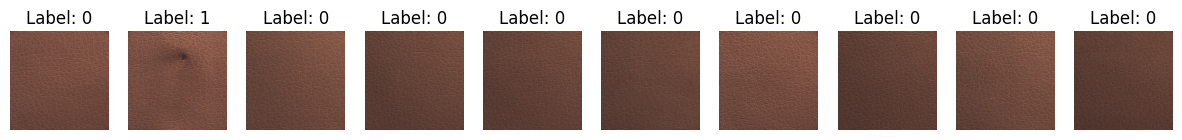

In [169]:
plot_images(images,labels,10)

In [170]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [171]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [277 277]


In [172]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [173]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [233 237]
Labels test distribution: [44 40]


In [174]:
cct_model = create_cct_model()

In [175]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 694ms/step - AUC: 0.5079 - accuracy: 0.4911 - loss: 1.0112 - val_AUC: 0.8900 - val_accuracy: 0.4894 - val_loss: 0.6810
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - AUC: 0.6381 - accuracy: 0.5361 - loss: 0.6763 - val_AUC: 0.9055 - val_accuracy: 0.7234 - val_loss: 0.5683
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.7759 - accuracy: 0.7300 - loss: 0.5945 - val_AUC: 0.9173 - val_accuracy: 0.7447 - val_loss: 0.4751
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - AUC: 0.8774 - accuracy: 0.7903 - loss: 0.5026 - val_AUC: 0.9291 - val_accuracy: 0.7660 - val_loss: 0.5029
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - AUC: 0.8866 - accuracy: 0.8057 - loss: 0.4933 - val_AUC: 0.9418 - val_accuracy: 0.8085 - val_loss: 0.4465
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.8577 - accuracy: 0.7388 - loss: 0.5316 - val_AUC: 0.9400 - val_accuracy: 0.7447 - val_loss: 0.5107
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━

In [176]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 971ms/step


ROC AUC: 0.9937499999999999
Accuracy: 0.9404761904761905
Precision: 0.9069767441860465
F1 Score: 0.9397590361445783
Recall (TPR): 0.975
False Positive Rate (FPR): 0.0909


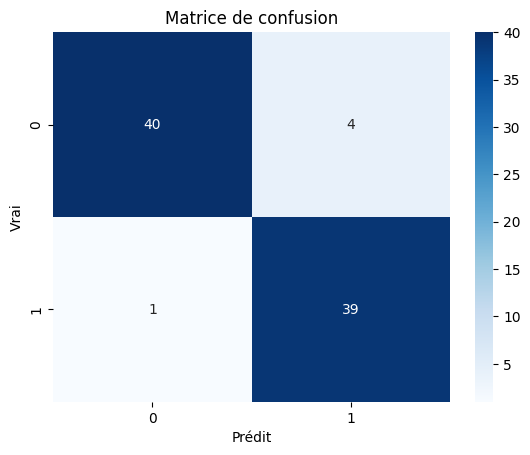

In [177]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## toothbrush

In [178]:

classe = "toothbrush"


images, labels = load_mvtec_images(path, classe)

In [179]:
images = images / 255.0  # Normalisation

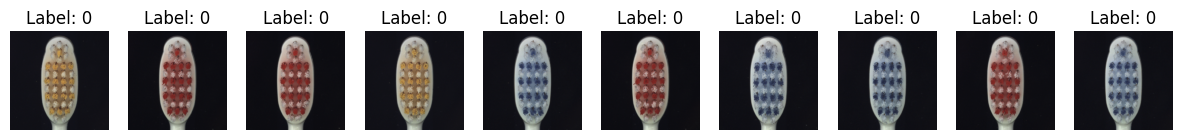

In [180]:
plot_images(images,labels,10)

In [181]:
images, labels = shuffle_data(images, labels)


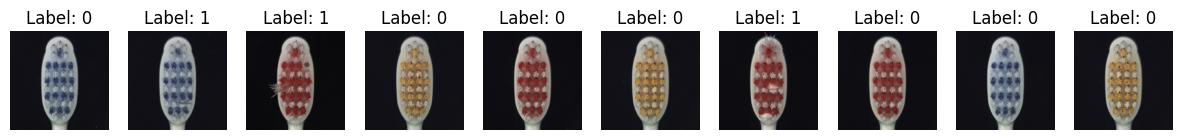

In [182]:
plot_images(images,labels,10)

In [183]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [184]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [72 72]


In [185]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [186]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [60 62]
Labels test distribution: [12 10]


In [187]:
cct_model = create_cct_model()

In [188]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - AUC: 0.3582 - accuracy: 0.5146 - loss: 1.2818 - val_AUC: 0.8875 - val_accuracy: 0.3846 - val_loss: 0.7077
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - AUC: 0.5852 - accuracy: 0.5165 - loss: 0.7474 - val_AUC: 0.9125 - val_accuracy: 0.6154 - val_loss: 0.6402
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - AUC: 0.4951 - accuracy: 0.5291 - loss: 0.7657 - val_AUC: 0.9250 - val_accuracy: 0.3846 - val_loss: 0.8027
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - AUC: 0.6531 - accuracy: 0.5105 - loss: 0.7241 - val_AUC: 0.9125 - val_accuracy: 0.6154 - val_loss: 0.6034
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - AUC: 0.6671 - accuracy: 0.5969 - loss: 0.6669 - val_AUC: 0.9125 - val_accuracy: 0.6923 - val_loss: 0.5885
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - AUC: 0.8035 - accuracy: 0.7234 - loss: 0.6129 - val_AUC: 0.9125 - val_accuracy: 0.3846 - val_loss: 0.7132
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - 

In [189]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ROC AUC: 0.975
Accuracy: 0.8636363636363636
Precision: 0.8181818181818182
F1 Score: 0.8571428571428571
Recall (TPR): 0.9
False Positive Rate (FPR): 0.1667


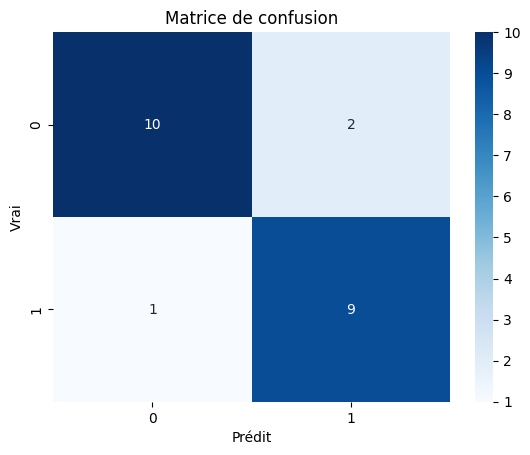

In [190]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## bottle

In [191]:

classe = "bottle"


images, labels = load_mvtec_images(path, classe)

In [192]:
images = images / 255.0  # Normalisation

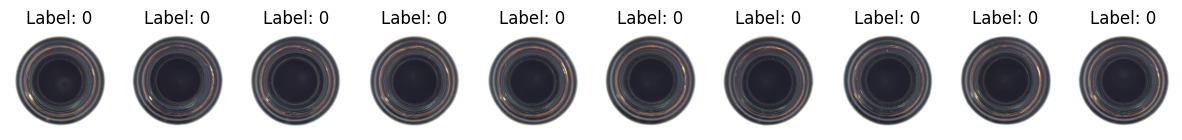

In [193]:
plot_images(images,labels,10)

In [204]:
images, labels = shuffle_data(images, labels)


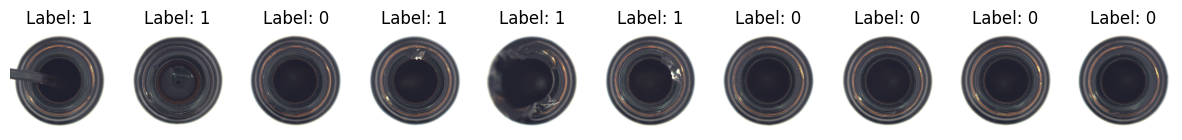

In [205]:
plot_images(images,labels,10)

In [206]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [207]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [229 229]


In [208]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [209]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [191 198]
Labels test distribution: [38 31]


In [210]:
cct_model = create_cct_model()

In [211]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 748ms/step - AUC: 0.4312 - accuracy: 0.4465 - loss: 1.0987 - val_AUC: 0.7754 - val_accuracy: 0.5641 - val_loss: 0.6816
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - AUC: 0.5464 - accuracy: 0.5368 - loss: 0.7260 - val_AUC: 0.8235 - val_accuracy: 0.5641 - val_loss: 0.6976
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - AUC: 0.6092 - accuracy: 0.5860 - loss: 0.6830 - val_AUC: 0.8783 - val_accuracy: 0.4615 - val_loss: 0.6853
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - AUC: 0.6264 - accuracy: 0.5547 - loss: 0.6787 - val_AUC: 0.8944 - val_accuracy: 0.7949 - val_loss: 0.5455
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - AUC: 0.8475 - accuracy: 0.7842 - loss: 0.5293 - val_AUC: 0.9626 - val_accuracy: 0.9231 - val_loss: 0.3946
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - AUC: 0.9455 - accuracy: 0.8920 - loss: 0.4085 - val_AUC: 0.9840 - val_accuracy: 0.9487 - val_loss: 0.3225
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━

In [212]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 809ms/step


ROC AUC: 1.0
Accuracy: 1.0
Precision: 1.0
F1 Score: 1.0
Recall (TPR): 1.0
False Positive Rate (FPR): 0.0000


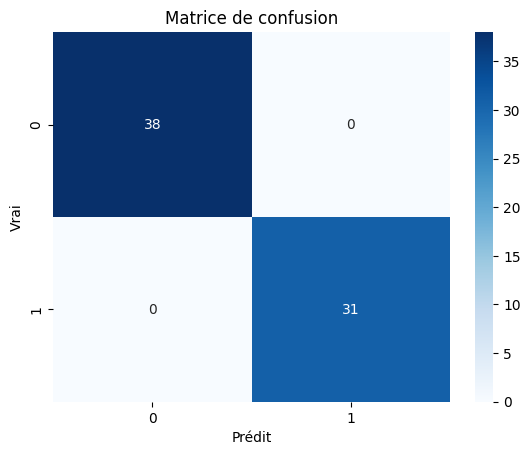

In [213]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## cable

In [266]:

classe = "cable"


images, labels = load_mvtec_images(path, classe)

In [267]:
images = images / 255.0  # Normalisation

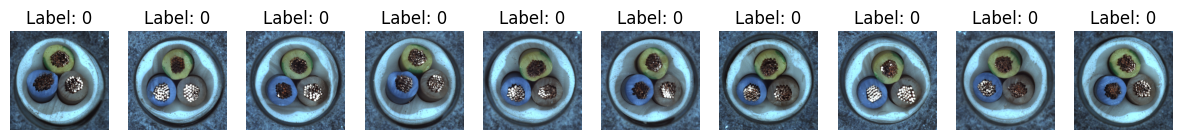

In [268]:
plot_images(images,labels,10)

In [269]:
images, labels = shuffle_data(images, labels)


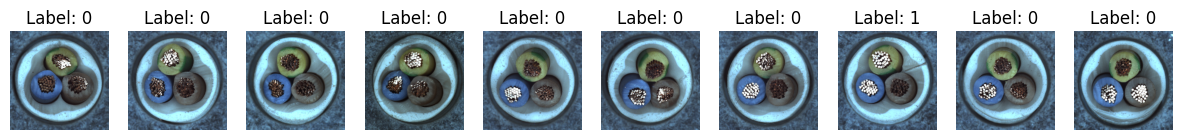

In [270]:
plot_images(images,labels,10)

In [271]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [272]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [282 282]


In [273]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [274]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [238 241]
Labels test distribution: [44 41]


In [275]:
cct_model = create_cct_model()

In [276]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 531ms/step - AUC: 0.4824 - accuracy: 0.4459 - loss: 1.0601 - val_AUC: 0.6128 - val_accuracy: 0.4583 - val_loss: 0.7878
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - AUC: 0.4617 - accuracy: 0.4780 - loss: 0.7396 - val_AUC: 0.7972 - val_accuracy: 0.4583 - val_loss: 0.7003
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - AUC: 0.6229 - accuracy: 0.5293 - loss: 0.6844 - val_AUC: 0.8103 - val_accuracy: 0.6042 - val_loss: 0.6796
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.6074 - accuracy: 0.5273 - loss: 0.6779 - val_AUC: 0.8628 - val_accuracy: 0.5208 - val_loss: 0.6900
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - AUC: 0.7260 - accuracy: 0.6527 - loss: 0.6339 - val_AUC: 0.9047 - val_accuracy: 0.5625 - val_loss: 0.8646
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - AUC: 0.7668 - accuracy: 0.6938 - loss: 0.6246 - val_AUC: 0.8995 - val_accuracy: 0.7292 - val_loss: 0.5393
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━

In [277]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 829ms/step


ROC AUC: 0.9135254988913526
Accuracy: 0.9058823529411765
Precision: 0.9459459459459459
F1 Score: 0.8974358974358975
Recall (TPR): 0.8536585365853658
False Positive Rate (FPR): 0.0455


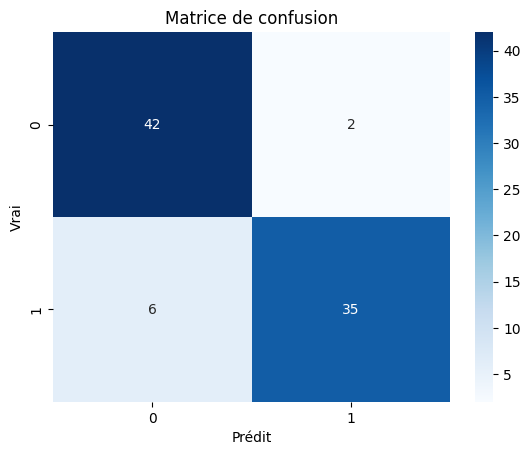

In [278]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


## screw

In [279]:

classe = "screw"


images, labels = load_mvtec_images(path, classe)

In [280]:
images = images / 255.0  # Normalisation

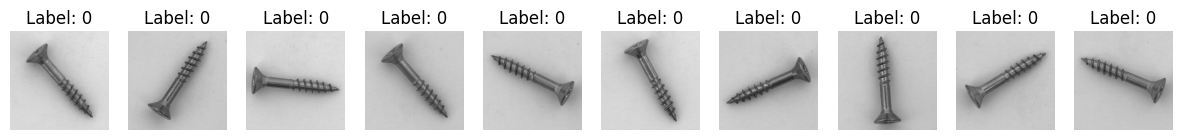

In [281]:
plot_images(images,labels,10)

In [282]:
images, labels = shuffle_data(images, labels)


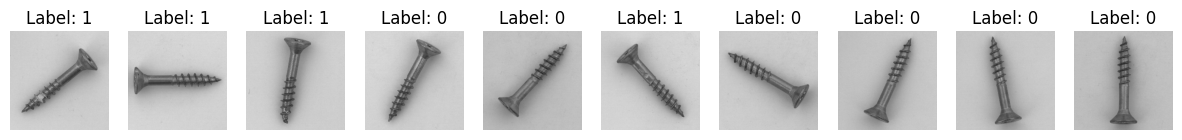

In [283]:
plot_images(images,labels,10)

In [284]:
x_balanced, y_balanced = balance_dataset_with_augmentation(images, labels)


In [285]:
print("Labels train distribution:", np.bincount(y_balanced))

Labels train distribution: [361 361]


In [286]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.15, random_state=42)





In [287]:
import numpy as np
print("Labels train distribution:", np.bincount(y_train))

print("Labels test distribution:", np.bincount(y_test))


Labels train distribution: [303 310]
Labels test distribution: [58 51]


In [288]:
cct_model = create_cct_model()

In [289]:
history = run_experiment(cct_model, x_train, y_train, x_test, y_test)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 520ms/step - AUC: 0.5172 - accuracy: 0.5038 - loss: 1.0585 - val_AUC: 0.6290 - val_accuracy: 0.5000 - val_loss: 0.7120
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - AUC: 0.4692 - accuracy: 0.5003 - loss: 0.7078 - val_AUC: 0.6805 - val_accuracy: 0.5000 - val_loss: 0.6955
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - AUC: 0.4472 - accuracy: 0.4717 - loss: 0.7116 - val_AUC: 0.7024 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - AUC: 0.4769 - accuracy: 0.4708 - loss: 0.7085 - val_AUC: 0.6800 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - AUC: 0.5224 - accuracy: 0.5260 - loss: 0.6997 - val_AUC: 0.7310 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - AUC: 0.5161 - accuracy: 0.4792 - loss: 0.7020 - val_AUC: 0.7107 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━

In [290]:
y_proba = cct_model.predict(x_test)
y_pred = (y_proba > 0.5).astype(int)
y_true = y_test

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step


ROC AUC: 0.8874239350912779
Accuracy: 0.7981651376146789
Precision: 0.8372093023255814
F1 Score: 0.7659574468085106
Recall (TPR): 0.7058823529411765
False Positive Rate (FPR): 0.1207


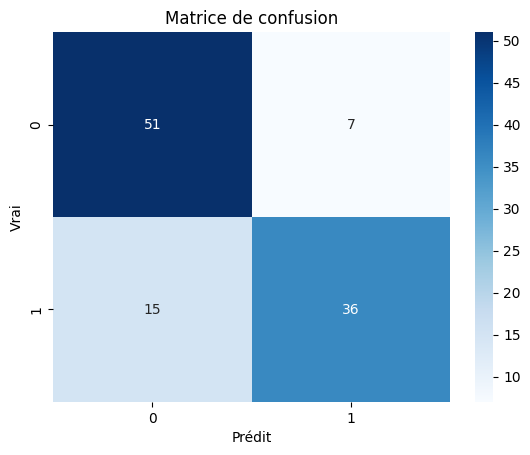

In [291]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul des métriques classiques
print("ROC AUC:", roc_auc_score(y_true, y_proba))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Recall (TPR):", recall_score(y_true, y_pred))  # identique à TPR



# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calcul TPR et FPR
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensibilité
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # Spécificité inversée


print(f"False Positive Rate (FPR): {fpr:.4f}")

# Affichage de la matrice de confusion
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()
